<div style="display:none">
  $
    \DeclareMathOperator*{\argmin}{arg\,min}    
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator*{\median}{median}
    \newcommand{\dydx}[2]{\frac{\partial #1}{\partial #2}}
    \newcommand{\x}{\times}
    \newcommand{\CWT}{\mathbb{C}\mathrm{WT}}
    \newcommand{\DTCWT}{\mathrm{DT}\CWT}
    \newcommand{\mat}[1]{\mathbf{#1}}
  $
</div>

# Learnable Soft Shrinkage Thresholds
In this work, we want to extend the soft-thresholding wavelet ideas initially introduced by Donoho and Johnstone in [Ideal Spatial Adaptation by Wavelet Shrinkage](http://statweb.stanford.edu/~imj/WEBLIST/1994/isaws.pdf), and later developed on by Chang, Yu and Vetterli in [Adaptive Wavelet Thresholding for Image Denoising and Compression](https://ieeexplore.ieee.org/document/862633).

In particular, given a noisy image and its clean version as a target, is it possible to learn via backpropagation the soft shrinkage thresholds? How much better are they than by using the estimated thresholds from Chang et. al?

Note that this is a toy problem - I will be using the clean image as a target and use the MSE to backpropagate values to the thresholds. In general denoising problems we of course do not have access to the clean image. Perhaps we can estimate noise as a next step, but we will leave this for future work.

## Background
Soft thresholding is a very popular and effective technique for denoising/compressing images. The basic technique involves:

- Taking a wavelet transform of the input - this has the advantage that the wavelet coefficients for most subbands of natural images are quite sparse.
![dwt](wt.png)

- Calculate a threshold $T$ that will convert the noisy image $Y=X+\epsilon$ to a denoised estimate $\hat{X}$. Do this by minimizing the Bayes Risk 
$$
r(T) = E[(\hat{X}(T) - X)^2]
$$ 

given some priors put on $p(\epsilon)$ (a common one being that $\epsilon \sim N(0, \sigma^2)$
- Use these thresholds on the wavelet bandpass coefficients (everything except from the LL output)
$$
\eta(x) = sgn(x) max(|x| -T, 0)
$$

![](softthresh.png)

- Reconstruct $\hat{X}$ from the newly shrunk coefficients.

In [1]:
# Import some plotting libraries
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from PIL import Image
import plotters # Can be obtained from https://github.com/fbcotter/plotters

# Import our numeric libraries
import numpy as np
import torch
import torch.nn as nn

# import our wavelet libraries. pytorch_wavelets can be obtained from
# https://github.com/fbcotter/pytorch_wavelets
import pywt
from pytorch_wavelets import DTCWTForward, DTCWTInverse, DWTForward, DWTInverse

In [2]:
# Load in our image and create a noisy version
im = np.array(Image.open('trinity.jpg')).astype('float')
np.random.seed(100)
im_noise = im + 20 * np.random.randn(*im.shape)
wave = 'db1'

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].imshow(plotters.normalize(im))
ax[1].imshow(plotters.normalize(im_noise))
plt.tight_layout()

<IPython.core.display.Javascript object>

In [3]:
# Define our signal to noise ratio function
def snr(x, y):
    ϵ = y - x
    Ex = np.mean(ϵ)
    Ex2 = np.mean(ϵ**2)
    std = np.sqrt(Ex2 - Ex**2)
    σ = np.std(x)
    
    snr = 20*np.log10(σ/std)
    return snr

print('SNR on our noisy image is: {}'.format(snr(im, im_noise)))

SNR on our noisy image is: 12.673146729916327


# Use Chang's Threshold to Denoise
From equation 12 in [Adaptive Wavelet Thresholding for Image Denoising and Compression](https://ieeexplore.ieee.org/document/862633), the wavelet soft thresholds that minimise the Bayes risk for the assumption that noise is gaussian are:
$$
T_B(\sigma_x) = \frac{\sigma^2}{\sigma_x}
$$

Where the $B$ subscript indicates that this is a function of subband, $\sigma_x$ is the variance of the noiseless wavelet coefficients, and $\sigma$ is the variance of the noise.

Note that we can estimate $\sigma$ robustly by calculating the median absolute deviation of the high-high wavelet coefficients at the finest level.

$$
\sigma \approx \frac{\text{median}(|x|)}{.6745}
$$

Then

$$
\sigma_X = \sqrt{\sigma_Y^2 - \sigma^2}
$$

In [4]:
def bayes_thresh(im, J=3):
    """ Calculates the soft shrink thresholds for the 3 subbands of a J
    level transform. the input image can have more than one channel. The
    resulting array has shape
    
    T[J, 3, C], where the zeroth dimension iterates of the scales, the first 
    dimension iterates over the bands LH, HL and HH, and the final dimension 
    iterates over the channels."""
    C = im.shape[-1]
    coeffs = pywt.wavedec2(im, wave, axes=(0, 1), level=J)

    # Estimate the noise variance using the median
    σ = np.zeros((C))
    for c in range(C):
        σ[c] = np.median(np.abs(coeffs[-1][-1][:, :, c].ravel())) / .6745

    # Estimate the noisy signal variance
    σy2 = np.zeros((J, 3, C))
    for j in range(J):
        for b, band in enumerate(['LH', 'HL', 'HH']):
            for c in range(C):
                σy2[j, b, c] = np.sum(coeffs[1 + j][b][:, :, c]**2) / \
                               coeffs[1 + j][b][:, :, c].size

    # Calculate σ_x = sqrt(σ_y^2 - σ^2)
    σx = np.sqrt(np.maximum(σy2 - σ**2, 0.0001))

    # Calculate T
    T = σ**2 / σx
    return T

def shrink(x, t):
    """ Given a wavelet coefficient and a threshold, shrink """
    if t == 0:
        return x
    m = np.abs(x)
    denom = m + (m < t).astype('float')
    gain = np.maximum(m - t, 0)/denom
    return x * gain
    
def shrink_coeffs(coeffs, T):
    """ Shrink the wavelet coefficients with the thresholds T. T should be an 
    array of shape (J, 3, C) for color images."""
    assert T.shape[0] == len(coeffs) - 1
    J = len(coeffs) - 1
    assert T.shape[1] == len(coeffs[1])
    assert T.shape[2] == len(coeffs[1][0][0,0])
    C = T.shape[2]
    
    coeffs_new = [None,] * (J + 1)
    coeffs_new[0] = np.copy(coeffs[0])
    for j in range(J):
        coeffs_new[1+j] = [np.zeros_like(coeffs[1+j][0]),
                           np.zeros_like(coeffs[1+j][1]),
                           np.zeros_like(coeffs[1+j][2])]        
        for b, band in enumerate(['LH', 'HL', 'HH']):
            for c in range(C):
                coeffs_new[1+j][b][:,:,c] = shrink(coeffs[1+j][b][:,:,c], T[j,b,c])
                
    return coeffs_new


Use the above to denoise the image

In [5]:
T = bayes_thresh(im_noise)
coeffs = pywt.wavedec2(im_noise, wave, axes=(0,1), level=3)
x_hat = pywt.waverec2(shrink_coeffs(coeffs, T), wave, axes=(0,1))

# Plot the result
fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(2, 4, hspace=0.1, wspace=0.1, top=0.95, bottom=0.05)
ax1 = plt.subplot(gs[0,1:3], xticks=[], yticks=[], title='Input Image')
ax2 = plt.subplot(gs[1,:2], xticks=[], yticks=[], 
                  title='Noisy Image (SNR={:.2f}dB)'.format(snr(im, im_noise)))
ax3 = plt.subplot(gs[1,2:], xticks=[], yticks=[], 
                  title='Denoised Image  (SNR={:.2f}dB)'.format(snr(im, x_hat)))
ax1.imshow(plotters.normalize(im))
ax2.imshow(plotters.normalize(im_noise))
ax3.imshow(plotters.normalize(x_hat))

<IPython.core.display.Javascript object>

# Analysis and tests
How many elements are set to 0 across each of the subbands? Let us plot the distributions of the wavelet coefficients for three scales before and after shrinkage. For plotting purposes, we do not show the number of zeros in the shrunk coefficients as this will greatly outweigh all other values.

In [6]:
#cA3, (cH3, cV3, cD3), (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs
J = 3
coeffs_unchanged = pywt.wavedec2(im_noise, wave, axes=(0,1), level=J)
shrunk_coeffs = shrink_coeffs(coeffs_unchanged, T)

def plot_hists(c1, c2, ax, ttl):
    bins = np.linspace(-2*c1.std(),2*c1.std(),50)
    ax[0].hist(c1.ravel(), bins=bins, color='r')
    ax[0].set_title(ttl)
    ylim = ax[0].get_ylim()
    
    keep_coeffs = np.abs(c2)>0
    ax[1].hist(c2[keep_coeffs].ravel(), bins=bins)
    ax[1].set_ylim(ylim)
    return keep_coeffs.sum()/keep_coeffs.size
    
for j in range(J):
    fig, ax = plt.subplots(3,2, figsize=(8,6), gridspec_kw={'hspace': .4})
    fig.suptitle('Scale {}'.format(J-j))
    for b, band in enumerate(['LH', 'HL', 'HH']):
        keep_percent = plot_hists(coeffs_unchanged[1+j][b][...,0], 
                                  shrunk_coeffs[1+j][b][...,0], ax[b], 
                                  ttl='{}, thresh= {:.1f}'.format(band, T[j,b,0]))
        ax[b,1].set_title('{:.1f}% coeffs are zero'.format(100*(1-keep_percent)))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We notice that the shrinking has a much larger impact on the finer coefficients. This is where it is easy to gain improvements in SNR as very little signal is here and a lot of noise.

## Test commutativity
Because the inverse wavelet transform is linear, $F(a+b) = F(a) + F(b)$. 

MSE is obviously not linear though, so 
$$L(a+b) = \frac{1}{NM}\sum_{i,j}(x_{i,j} - \hat{x}_{i,j})^2 = \frac{1}{NM}\sum_{i,j}(x_{i,j} - F(a+b))^2 \\
= \frac{1}{NM}\sum_{i,j}\left(x_{i,j} - (F(a)+F(b))\right)^2 \\
= L(a) + L(b) - \frac{1}{NM}\sum_{i,j}\left(x_{i,j}^2 - 2F(a)F(b)\right)$$

The nice thing about orthogonal wavelets is that $\sum_{i,j}F(a)F(b) = 0$, this means that $L(a+b) = L(a) + L(b) + C$. Then, we can independently minimize each subband's threshold.

## Test linearity with subband coefficients
Annoyingly, we can only use haar for the moment. 
If we us another orthogonal wavelet, the subands are a bigger shape, and 
the above orthogonal property only holds when you set the right wavelet 
coefficients to nonzero.

In [7]:
coeffs1 = pywt.wavedec2(im_noise, wave, axes=(0,1), level=J)
coeffs_zero = pywt.wavedec2(np.zeros_like(im_noise), wave, axes=(0,1), level=J)
# Set level 1 LH to be nonzero
coeffs_zero[1][0][:] = coeffs1[1][0]
ya = pywt.waverec2(coeffs_zero, wave, axes=(0,1))
# Set level 1 HL to also be nonzero
coeffs_zero[1][1][:] = coeffs1[1][1]
yab = pywt.waverec2(coeffs_zero, wave, axes=(0,1))
# Set level 1 LH to be nonzero
coeffs_zero[1][0][:] = np.zeros_like(coeffs1[1][0])
yb = pywt.waverec2(coeffs_zero, wave, axes=(0,1))
np.testing.assert_array_almost_equal(ya+yb, yab, decimal=5)

## Test linearity with shrunk subband coefficients

In [8]:
coeffs1 = pywt.wavedec2(im_noise, wave, axes=(0,1), level=J)
coeffs_zero = pywt.wavedec2(np.zeros_like(im_noise), wave, axes=(0,1), level=J)

# Set level 1 LH to be nonzero
coeffs_zero[1][0][:,:,0] = shrink(coeffs1[1][0][:,:,0], T[0,0,0])
ya = pywt.waverec2(coeffs_zero, wave, axes=(0,1))

# Set level 1 HL to also be nonzero
coeffs_zero[1][1][:,:,0] = shrink(coeffs1[1][1][:,:,0], T[0,1,0])
yab = pywt.waverec2(coeffs_zero, wave, axes=(0,1))

# Set level 1 LH to be nonzero
coeffs_zero[1][0][:,:,0] = np.zeros_like(coeffs1[1][0][:,:,0])
yb = pywt.waverec2(coeffs_zero, wave, axes=(0,1))
np.testing.assert_array_almost_equal(ya+yb, yab, decimal=5)

## Test Orthogonality
Above I have stated that $\sum_{i,j}F(a)F(b) = 0$. Let us test this

In [9]:
coeffs_zero = pywt.wavedec2(np.zeros_like(im_noise), wave, axes=(0,1), level=J)
coeffs_zero[0][:] = np.random.randn(*coeffs_zero[0].shape)
ya = pywt.waverec2(coeffs_zero, wave, axes=(0,1))

coeffs_zero = pywt.wavedec2(np.zeros_like(im_noise), wave, axes=(0,1), level=J)
coeffs_zero[1][1][:] = np.random.randn(*coeffs_zero[1][0].shape)
yb = pywt.waverec2(coeffs_zero, wave, axes=(0,1))

coeffs_zero = pywt.wavedec2(np.zeros_like(im_noise), wave, axes=(0,1), level=J)
coeffs_zero[1][2][:] = np.random.randn(*coeffs_zero[1][0].shape)
yc = pywt.waverec2(coeffs_zero, wave, axes=(0,1))

coeffs_zero = pywt.wavedec2(np.zeros_like(im_noise), wave, axes=(0,1), level=J)
coeffs_zero[2][0][:] = np.random.randn(*coeffs_zero[2][0].shape)
yd = pywt.waverec2(coeffs_zero, wave, axes=(0,1))

coeffs_zero = pywt.wavedec2(np.zeros_like(im_noise), wave, axes=(0,1), level=J)
coeffs_zero[3][2][:] = np.random.randn(*coeffs_zero[3][2].shape)
ye = pywt.waverec2(coeffs_zero, wave, axes=(0,1))


np.testing.assert_array_almost_equal(np.sum(ya*yb), np.zeros_like(ya))
np.testing.assert_array_almost_equal(np.sum(ya*yc), np.zeros_like(ya))
np.testing.assert_array_almost_equal(np.sum(ya*yd), np.zeros_like(ya))
np.testing.assert_array_almost_equal(np.sum(ya*ye), np.zeros_like(ya))
np.testing.assert_array_almost_equal(np.sum(yb*yc), np.zeros_like(ya))
np.testing.assert_array_almost_equal(np.sum(yb*yd), np.zeros_like(ya))
np.testing.assert_array_almost_equal(np.sum(yb*ye), np.zeros_like(ya))
np.testing.assert_array_almost_equal(np.sum(yc*yd), np.zeros_like(ya))
np.testing.assert_array_almost_equal(np.sum(yc*ye), np.zeros_like(ya))
np.testing.assert_array_almost_equal(np.sum(yd*ye), np.zeros_like(ya))

## Test Loss equations

In [10]:
def mse_loss(x, x_hat=im):
    return np.mean((x-x_hat)**2)

# Calculate the mean removed image
coeffs = pywt.wavedec2(im_noise, wave, axes=(0,1), level=J)
coeffs_zero = pywt.wavedec2(np.zeros_like(im_noise), wave, axes=(0,1), level=J)
coeffs_zero[0] = np.copy(coeffs[0])
μ = pywt.waverec2(coeffs_zero, wave, axes=(0,1))
im2 = im - μ

# let F(a) be passing through level 1 LH
coeffs_zero = pywt.wavedec2(np.zeros_like(im_noise), wave, axes=(0,1), level=J)
coeffs_zero[1][0][:,:,0] = shrink(coeffs[1][0][:,:,0], T[0,0,0])
Fa = pywt.waverec2(coeffs_zero, wave, axes=(0,1))
La = mse_loss(Fa, im2)

# let F(b) be passing through level 1 HL
coeffs_zero = pywt.wavedec2(np.zeros_like(im_noise), wave, axes=(0,1), level=J)
coeffs_zero[1][1][:,:,0] = shrink(coeffs[1][1][:,:,0], T[0,1,0])
Fb = pywt.waverec2(coeffs_zero, wave, axes=(0,1))
Lb = mse_loss(Fb, im2)

coeffs_zero = pywt.wavedec2(np.zeros_like(im_noise), wave, axes=(0,1), level=J)
coeffs_zero[1][0][:,:,0] = shrink(coeffs[1][0][:,:,0], T[0,0,0])
coeffs_zero[1][1][:,:,0] = shrink(coeffs[1][1][:,:,0], T[0,1,0])
Fab = pywt.waverec2(coeffs_zero, wave, axes=(0,1))
Lab = mse_loss(Fab, im2)

np.testing.assert_almost_equal(Lab, La + Lb - np.mean((im2)**2))

To expand on the loss equations, consider $L(a,b, \ldots , z)$. By simple induction, we can say
$$L(a+b+\ldots +z) = L(a) + L(b+\ldots +z) - \frac{1}{NM}\sum_{i,j}(x_{i,j})^2$$
and
$$L(a+b+\mu) = L(a+\mu) + L(b+\mu) - \frac{1}{NM}\sum_{i,j}(x_{i,j} - F(\mu))^2$$
Where $F(\mu)$ is the inverse wavelet transform of the non-zero mean coefficients (in our example, this is simply just the LL coefficients).

In [11]:
coeffs = pywt.wavedec2(im_noise, wave, axes=(0,1), level=J)
coeffs_zero = pywt.wavedec2(np.zeros_like(im_noise), wave, axes=(0,1), level=J)

coeffs_zero[0] = coeffs[0]
Fμ = pywt.waverec2(coeffs_zero, wave, axes=(0,1))

coeffs_zero[1][0][:,:,0] = shrink(np.copy(coeffs[1][0][:,:,0]), T[0,0,0])
Faμ = pywt.waverec2(coeffs_zero, wave, axes=(0,1))
Laμ = mse_loss(Faμ)

coeffs_zero[1][1][:,:,0] = shrink(np.copy(coeffs[1][1][:,:,0]), T[0,1,0])
Fabμ = pywt.waverec2(coeffs_zero, wave, axes=(0,1))
Labμ = mse_loss(Fabμ)

coeffs_zero[1][0][:,:,0] = np.zeros_like(coeffs[1][0][:,:,0])
Fbμ = pywt.waverec2(coeffs_zero, wave, axes=(0,1))
Lbμ = mse_loss(Fbμ)

np.testing.assert_almost_equal(Labμ, Laμ + Lbμ - np.mean((im-Fμ)**2))

# Plot MSE as a function of Threshold for each subband
This nice separability of the loss means we can minimize $L(a)$ wrt $T_a$, then do the same for $L(b)$, and so on. This should give us a global minimum.

In [12]:
# Calculate the mean removed image
coeffs = pywt.wavedec2(im_noise, wave, axes=(0,1), level=J)
coeffs_zero = pywt.wavedec2(np.zeros_like(im_noise), wave, axes=(0,1), level=J)
coeffs_zero[0] = np.copy(coeffs[0])
μ = pywt.waverec2(coeffs_zero, wave, axes=(0,1))
im2 = im - μ

# Iterate over all the subbands, setting all others to zero and find the 
# MSE of the reconstructed images for a range of thresholds.
N = 20
J = 3
C = 3
mses = np.zeros((J,3,C,N))
T_mse = np.zeros((J,3,C))
Ts = np.zeros((J,3,C,N))
for j in range(J):
    for b, band in enumerate(['LH', 'HL', 'HH']):
        for c in range(C):
            coeffs_zero = pywt.wavedec2(
                np.zeros_like(im_noise), wave, axes=(0,1), level=J)
            k = np.copy(coeffs[1+j][b][:,:,c])
            
            # Calculate 20 points from 0 to double the bayes estimated thresh
            Ts[j,b,c,:] = np.linspace(
                0, 3*min(T[j,b,c], .4*np.abs(k).max()), N)
            
            # Calculate the mse at the bayes estimate thresh
            coeffs_zero[1+j][b][:,:,c] = shrink(k, T[j,b,c])
            x_hat = pywt.waverec2(coeffs_zero, wave, axes=(0,1))
            T_mse[j,b,c] = np.mean((x_hat - im2)**2)
            
            # Calculate the mse at each of the N points
            for i,t in enumerate(Ts[j,b,c]):
                coeffs_zero[1+j][b][:,:,c] = shrink(k, t)
                x_hat = pywt.waverec2(coeffs_zero, wave, axes=(0,1))
                mses[j,b,c,i] = np.mean((x_hat - im2)**2)

Now that we have calculated the MSEs for a range of thresholds for each subband, plot the results

In [13]:
colors = 'RGB'
c = colors.find('R')
T = bayes_thresh(im_noise)

plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(3,3)
gs.update(left=0.1, right=0.95, wspace=0.05, hspace=.2, top=0.95)
for j in range(J):
    for b, band in enumerate(['LH', 'HL', 'HH']):        
        if b == 0:            
            ax = plt.subplot(gs[j,b])
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax0 = ax            
        else:
            ax = plt.subplot(gs[j,b])
            plt.setp(ax.get_yticklabels(), visible=False)
        
        ax.plot(Ts[j,b,c], mses[j,b,c])
        if j == 0 and b == 1:
            ax.axhline(y=T_mse[j,b,c], ls='--',c='r', 
                       label='MSE for bayes calculated thresh')
            ax.legend()
        else:
            ax.axhline(y=T_mse[j,b,c], ls='--',c='r')
        ax.axvline(x=T[j,b,c], ls='--',c='r')
        ax.set_title('Scale {} {}'.format(J-j, band))
        ax.set_xlim(0, max(Ts[j,b,c,-1], T[j,b,c]*1.1))
        

<IPython.core.display.Javascript object>

Very interesting, the bayes calculated threshold is very near the true minimum for almost all the subbands!

## Convexity Test
Test the above assertion, that minimizing each threshold independently results in minimizing the overall MSE. First, search over the above plots for
$$T^{*} = \text{argmin}_{T} MSE(x, \hat{x})$$

In [14]:
# Calculate T*
mse_min = np.argmin(mses, axis=-1)
T_star = np.zeros_like(T)
for j in range(J):
    for b in range(3):
        for c in range(C):
            T_star[j,b,c] = Ts[j,b,c, mse_min[j,b,c]]
            
# Calculate the MSE with T* vs with the bayes estimated thresholds
coeffs = pywt.wavedec2(im_noise, wave, axes=(0,1), level=J)
x_hat_min = pywt.waverec2(shrink_coeffs(coeffs, T_star), wave, axes=(0,1))
x_hat_bayes = pywt.waverec2(shrink_coeffs(coeffs, T), wave, axes=(0,1))
print('Bayes Shrink MSE is {}'.format(np.sum((im-x_hat_bayes)**2/im.size)))
print('Min shrink MSE is {}'.format(np.sum((im-x_hat_min)**2/im.size)))        

Bayes Shrink MSE is 85.4250447125913
Min shrink MSE is 82.9359235938321


We haven't really proven it's the global minimum, but we have proven that it is at least better than using the bayes shrink thresholds.

# Find threshold by gradients

## Finite Differences
The above curve for $L(T)$ looks quite smooth, so it seems plausible that the gradients are smooth. Let us test these via finite differences

In [15]:
fig, ax = plt.subplots(1)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.plot(Ts[0,0,1], mses[0,0,1])
ax.set_title('LH subband for scale 3')
ax.set_xlabel('T')
ax.set_ylabel('L(T)')
plt.tight_layout()

<IPython.core.display.Javascript object>

In [16]:
# Calculate the mean removed image
coeffs = pywt.wavedec2(im_noise, wave, axes=(0,1), level=J)
coeffs_zero = pywt.wavedec2(np.zeros_like(im_noise), wave, axes=(0,1), 
                            level=J)
coeffs_zero[0] = np.copy(coeffs[0])
μ = pywt.waverec2(coeffs_zero, wave, axes=(0,1))
im2 = im - μ

def F(t):
    coeffs = pywt.wavedec2(im_noise, wave, axes=(0,1), level=J)
    coeffs_zero = pywt.wavedec2(np.zeros_like(im_noise), wave, axes=(0,1), 
                                level=J)
    coeffs_zero[1][0][:,:,1] = shrink(coeffs[1][0][:,:,1], t)
    x_hat = pywt.waverec2(coeffs_zero, wave, axes=(0,1))
    return x_hat

def L(t):    
    return np.mean((im2 - F(t))**2)
    
def dLdt(T, dt=.1):    
    return (L(T+dt) - L(T-dt))/(2*dt)

print('Gradient at T=5 is {:.4f}'.format(dLdt(5)))
print('Gradient at T=20 is {:.4f}'.format(dLdt(20)))

Gradient at T=5 is -0.0592
Gradient at T=20 is 0.0342


This matches up with the plotted curve

## Manual backpropagation

Analytically what are the gradients?
$$
L=\frac{1}{MN}(\hat{X}-X)^2
$$

by modifying $T$? 

- It is trivial to calculate $\frac{dL}{d\hat{X}}$. 
- Calculating $\frac{d\hat{X}}{dw}$ is not too difficult - simply need to take the forward wavelet transform with time reversed synthesis filters as the analysis filters. As we used orthogonal wavelets, this is already the case.
- Calculating $\frac{dw}{dT}$ is also trivial - I have done this already. To remind us, if:

$$
w = \eta_T(x) = x \cdot \frac{max(|x|-t, 0)}{|x|}
$$

then 
$$
\frac{dw}{dT} = -\text{sign} (x)\mathbb{1}(|x| - t > 0) = -\text{sign}(w) \in \{-1, 0, 1 \}
$$

and 
$$
\frac{dw}{dx} = \mathbb{1}(|x| - t > 0)
$$

In [17]:
plt.figure()
t = 1.6
x = np.linspace(-5,5,100)
w = shrink(x, t)
dwdt = -np.sign(w)
plt.plot(x, w, label='w')
plt.plot(x, dwdt, label='dw/dt')
plt.legend(frameon=True)
plt.axhline(y=0, color='k', linewidth=.5)
plt.axvline(x=0, color='k', linewidth=.5)
plt.grid(ls='dashed')

<IPython.core.display.Javascript object>

In [18]:
def dLdX_hat(x_hat, im):
    return 2*(x_hat-im)/x_hat.size

def dX_hatdw(x_hat):
    coeffs = pywt.wavedec2(x_hat, wave, axes=(0,1), level=J)
    return coeffs[1][0][:,:,1]

def dwdT(w, T):
    coeffs = pywt.wavedec2(im_noise, wave, axes=(0,1), level=J)
    g = shrink(coeffs[1][0][:,:,1], T)
    g = -np.sign(g)
    return np.sum(g*w)

def np_backprop(T):
    return dwdT(dX_hatdw(dLdX_hat(F(T), im2)), T)

print('Gradient at T=5 is {:.4f}'.format(np_backprop(5)))
print('Gradient at T=20 is {:.4f}'.format(np_backprop(20)))

Gradient at T=5 is -0.0592
Gradient at T=20 is 0.0342


## autograd (using pytorch)
Pytorch does have its own soft thresh function, but it only gives gradients w.r.t the input.

To work around this, we have to define our own autograd function for the soft threshold which gives gradients w.r.t. the input and the thresholds:

In [19]:
from torch.autograd import Function
class SoftShrink_fn(Function):
    @staticmethod
    def forward(ctx, x, t):
        y = nn.functional.softshrink(x, t.item())
        ctx.save_for_backward(torch.sign(y))
        return y

    @staticmethod
    def backward(ctx, dy):
        din, = ctx.saved_tensors
        dx, dt = None, None
        if ctx.needs_input_grad[0]:
            dx = dy * din * din
        if ctx.needs_input_grad[1]:
            dt = -torch.sum(dy * din)
        return dx, dt

class SoftShrink(nn.Module):                                                                                   
    def __init__(self, t_init):                                                                                
        super().__init__()                                                                                     
        self.t = nn.Parameter(torch.tensor(t_init))                                                    
                                                                                                               
    def forward(self, x):                      
        """ Applies Soft Thresholding to x """ 
        return SoftShrink_fn.apply(x, self.t)
    
from torch.autograd import gradcheck
x = torch.randn(10,10, requires_grad=True, dtype=torch.double)
t = torch.tensor(1., requires_grad=True, dtype=torch.double)
gradcheck(SoftShrink_fn.apply, (x,t))

True

Use this to calculate the gradient at $T=5$ and $T=20$ as we did for the finite differences above

In [21]:
dwt = DWTForward(C=3,J=3, wave='db1')
iwt = DWTInverse(C=3, wave='db1')
X = torch.tensor(im.astype('float32').transpose((2,0,1))[None,:])
Y = torch.tensor(im_noise.astype('float32').transpose((2,0,1))[None,:], 
                 requires_grad=True)

# Calculate the mean removed image
coeffs = dwt(Y)
zeros = dwt(torch.zeros_like(Y))
zeros[0] = coeffs[0]
X2 = X - iwt(zeros)
shrinker = SoftShrink(5.0)

def F_torch(T):
    # Shrink the LH of the first scale
    coeffs = dwt(Y)
    zeros = dwt(torch.zeros_like(Y))
    shrinker.t.data = torch.tensor(T)
    c = shrinker(coeffs[1][-1])
    c[:,0] = 0.
    c[:,2] = 0.
    c[:,1,1:] = 0.
    coeffs_shrink = [
        torch.zeros_like(coeffs[0]),
        [torch.zeros_like(coeffs[1][0]),
         torch.zeros_like(coeffs[1][1]),
         c
        ]
    ]
    return iwt(coeffs_shrink)

def L_torch(T):
    return torch.mean((X2 - F_torch(T))**2)

y = L_torch(5.0)
y.backward(retain_graph=True)
print('Gradient at T=5 is {:.4f}'.format(shrinker.t.grad.item()))
shrinker.t.grad.zero_()
y = L_torch(20.0)
y.backward(retain_graph=True)
print('Gradient at T=20 is {:.4f}'.format(shrinker.t.grad.item()))

Gradient at T=5 is -0.0592
Gradient at T=20 is 0.0342


Good! this agrees with the finite differences approximation to the gradient. Now that we have a function to calculate gradients, let us minimize!

# Optimize
We will need to slightly modify the above softshrink function to work with channels of input:

In [23]:
class SoftShrink_ch_fn(Function):
    @staticmethod
    def forward(ctx, x, t, C):
        y = torch.zeros_like(x)
        for c in range(C):
            for i in range(3):
                y[:,c,i] = nn.functional.softshrink(x[:,c,i], t.data[c,i])
        ctx.save_for_backward(torch.sign(y))
        return y

    @staticmethod
    def backward(ctx, dy):
        din, = ctx.saved_tensors
        dx, dt = None, None
        if ctx.needs_input_grad[0]:
            dx = dy * din * din
        if ctx.needs_input_grad[1]:
            dt = -torch.sum(dy * din, dim=(0,3,4))
        return dx, dt, None

class SoftShrink_ch(nn.Module):                                                                                   
    def __init__(self, C, t_init, t_grad=True):
        super().__init__()
        assert t_init.shape[-1] == 3
        assert t_init.shape[0] == C
        self.t = nn.Parameter(torch.tensor(t_init).float())
        self.constrain = nn.ReLU()
        self.C = C

    @property
    def thresh(self):
        return self.constrain(self.t)

    def forward(self, x):
        """ Applies Soft Thresholding to x """
        if x.shape == torch.Size([0]):
            return x
        else:
            assert x.shape[1] == self.C
            return SoftShrink_ch_fn.apply(x, self.thresh, self.C)
        
x = torch.randn(1,3,3,4,4, dtype=torch.double, requires_grad=True)
t = torch.rand(3,3, dtype=torch.double, requires_grad=True)
y = SoftShrink_ch_fn.apply(x, t, 3)
gradcheck(SoftShrink_ch_fn.apply, (x,t,3))

True

Now that we have this, create the 'net' that shrinks coefficients:

In [27]:
class MyThresh(nn.Module):
    def __init__(self, t_init=None):
        super().__init__()
        if t_init is None:
            t_init = np.random.rand(3,3,3)
        self.dwt = DWTForward(C=3,J=3, wave=wave)
        self.iwt = DWTInverse(C=3, wave=wave)
        self.shrinkers = nn.ModuleList([
            SoftShrink_ch(C=3, t_init=t_init[0]),
            SoftShrink_ch(C=3, t_init=t_init[1]),
            SoftShrink_ch(C=3, t_init=t_init[2])
        ])
    
    def forward(self, x):
        coeffs = self.dwt(x)
        coeffs[1][0] = self.shrinkers[0](coeffs[1][0])
        coeffs[1][1] = self.shrinkers[1](coeffs[1][1])
        coeffs[1][2] = self.shrinkers[2](coeffs[1][2])
        y = self.iwt(coeffs)
        return y

In [28]:
def get_lr(optim):
    lrs = []
    for p in optim.param_groups:
        lrs.append(p['lr'])
    if len(lrs) == 1:
        return lrs[0]
    else:
        return lrs

def minimize(T_init=None):
    DeNoise = MyThresh(T_init)    
    optimizer = torch.optim.Adam(DeNoise.parameters(), lr=2e-0)
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(
    #    optimizer, milestones=[120, 180, 220], gamma=0.5)
    criterion = torch.nn.MSELoss(reduction='elementwise_mean')
    for step in range(250):
        #scheduler.step()
        optimizer.zero_grad()
        Z = DeNoise(Y)
        mse = torch.mean((X - Z)**2)
        loss = criterion(Z,X)
        if torch.isnan(mse):
            raise ValueError('Nan encountered in training')
        if step % 10 == 0:
            print('Step [{:02d}]:\tlr: {:.1e}\tmse: {:.2f}'.format(
                step, get_lr(optimizer), mse.item()))
        loss.backward()
        optimizer.step()
    return DeNoise

In [29]:
Denoise = minimize()

Step [00]:	lr: 2.0e+00	mse: 382.41
Step [10]:	lr: 2.0e+00	mse: 117.28
Step [20]:	lr: 2.0e+00	mse: 88.03
Step [30]:	lr: 2.0e+00	mse: 84.91
Step [40]:	lr: 2.0e+00	mse: 83.98
Step [50]:	lr: 2.0e+00	mse: 83.60
Step [60]:	lr: 2.0e+00	mse: 83.27
Step [70]:	lr: 2.0e+00	mse: 83.11
Step [80]:	lr: 2.0e+00	mse: 83.02
Step [90]:	lr: 2.0e+00	mse: 82.98
Step [100]:	lr: 2.0e+00	mse: 82.95
Step [110]:	lr: 2.0e+00	mse: 82.93
Step [120]:	lr: 2.0e+00	mse: 82.92
Step [130]:	lr: 2.0e+00	mse: 82.90
Step [140]:	lr: 2.0e+00	mse: 82.89
Step [150]:	lr: 2.0e+00	mse: 82.88
Step [160]:	lr: 2.0e+00	mse: 82.87
Step [170]:	lr: 2.0e+00	mse: 82.86
Step [180]:	lr: 2.0e+00	mse: 82.86
Step [190]:	lr: 2.0e+00	mse: 82.85
Step [200]:	lr: 2.0e+00	mse: 82.85
Step [210]:	lr: 2.0e+00	mse: 82.84
Step [220]:	lr: 2.0e+00	mse: 82.84
Step [230]:	lr: 2.0e+00	mse: 82.83
Step [240]:	lr: 2.0e+00	mse: 82.83


Plot the new thresholds compared to the bayes threshold ones:

<IPython.core.display.Javascript object>


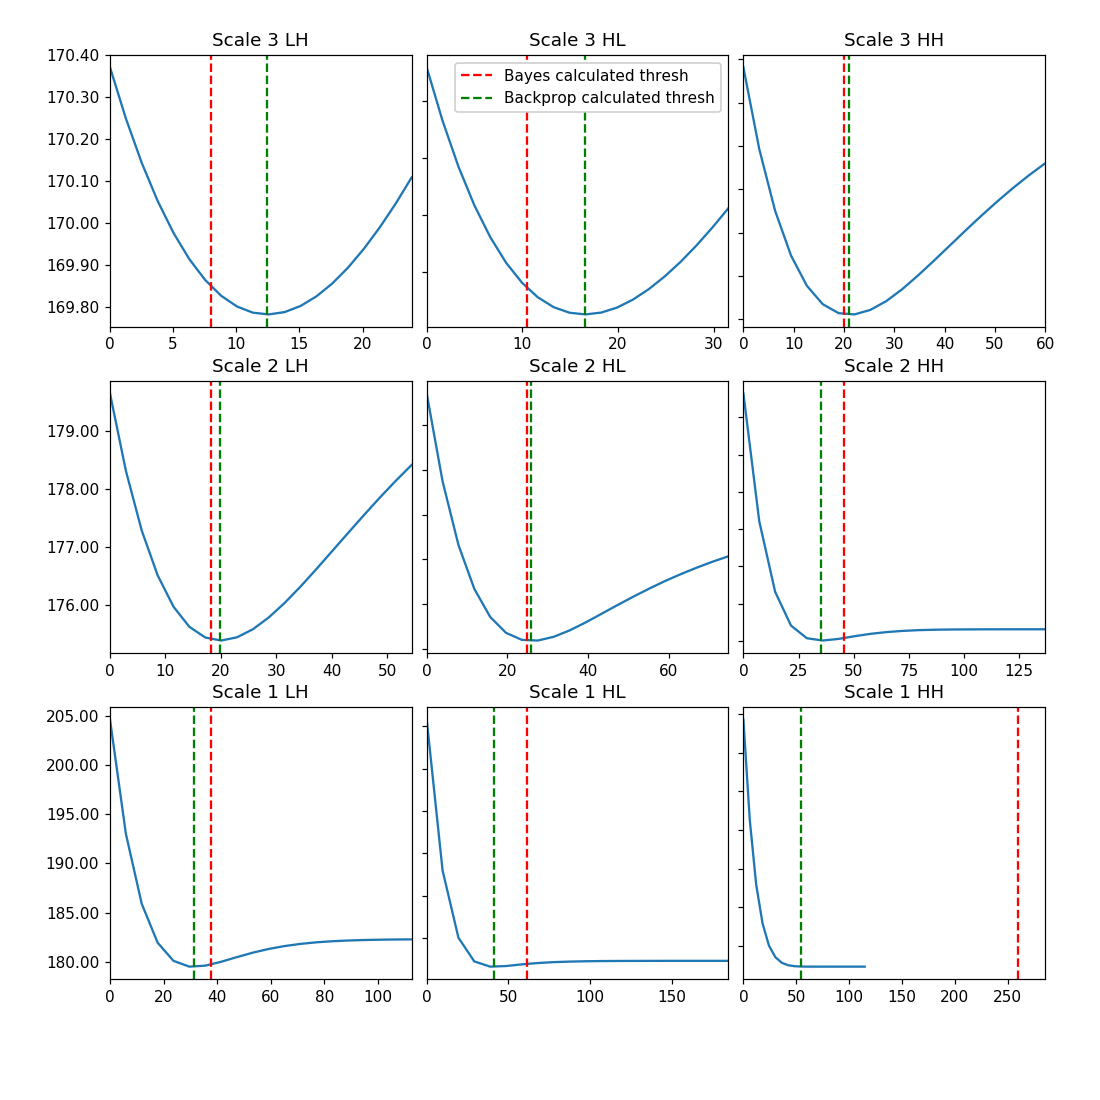

In [35]:
colors = 'RGB'
c = colors.find('R')
T = bayes_thresh(im_noise)

plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(3,3)
gs.update(left=0.1, right=0.95, wspace=0.05, hspace=.2, top=0.95)
for j in range(J):
    for b, band in enumerate(['LH', 'HL', 'HH']):        
        if b == 0:            
            ax = plt.subplot(gs[j,b])
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax0 = ax            
        else:
            ax = plt.subplot(gs[j,b])
            plt.setp(ax.get_yticklabels(), visible=False)
        
        ax.plot(Ts[j,b,c], mses[j,b,c])
        if j == 0 and b == 1:            
            ax.axvline(x=T[j,b,c], ls='--',c='r',
                       label='Bayes calculated thresh')   
            ax.axvline(x=Denoise.shrinkers[2].t[c,1], ls='--', c='g', 
                       label='Backprop calculated thresh')
            ax.legend(framealpha=1)
        else:
            ax.axvline(x=T[j,b,c], ls='--',c='r')
            ax.axvline(x=Denoise.shrinkers[J-1-j].t[c,b], ls='--', c='g')
             
        ax.set_title('Scale {} {}'.format(J-j, band))
        ax.set_xlim(0, max(Ts[j,b,c,-1], T[j,b,c]*1.1))
        

It works! We have learned the optimal thresholds via backpropagation. As mentioned at the beginning of this notebook however, this is still not ideal as we needed the noiseless image to calculate the MSE.